In [12]:
import itertools
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import csv

def read_and_process_csv(file_name):
    matrix = []

    with open(file_name, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            new_row = [np.nan if cell == '' else float(cell) for cell in row]
            matrix.append(new_row)

    matrix = np.array(matrix, dtype=float)
    n = matrix.shape[0]
    matrix[np.isnan(matrix)] = 0

    for i in range(n):
        for j in range(i+1, n):
            matrix[i, j] = matrix[j, i]

    # matrix_nonzero = matrix[matrix > 0]
    # matrix_min = np.min(matrix_nonzero)
    # matrix_max = np.max(matrix_nonzero)
    # matrix[matrix > 0] = (matrix[matrix > 0] - matrix_min) / (matrix_max - matrix_min)

    matrix[matrix == 0] = 1000

    return matrix


def combined_cost_and_transport(path, flight_df, train_df, max_flights, max_trains):
    total_cost = 0
    transport = []
    flight_count = 0
    train_count = 0
    for i in range(len(path) - 1):
        flight_cost = flight_df.loc[path[i], path[i + 1]]
        train_cost = train_df.loc[path[i], path[i + 1]]
        if flight_count < max_flights and (train_count >= max_trains or flight_cost < train_cost):
            total_cost += flight_cost
            transport.append("Airplane")
            flight_count += 1
        elif train_count < max_trains:
            total_cost += train_cost
            transport.append("Train")
            train_count += 1
        else:
            return float('inf'), transport
    return total_cost, transport

def tsp_bruteforce_combined(flight_data, train_data, start, max_flights, max_trains):
    cities = flight_data.columns.tolist()
    cities.remove(start)
    min_cost = float('inf')
    min_path = None
    min_transport = None

    # 修改此处，使用tqdm包装itertools.permutations
    for path in tqdm(list(itertools.permutations(cities)), desc="Calculating progress"):
        path = (start,) + path + (start,)
        cost, transport = combined_cost_and_transport(path, flight_data, train_data, max_flights, max_trains)
        if cost < min_cost:
            min_cost = cost
            min_path = path
            min_transport = transport

    return min_path, min_cost, min_transport

# London	Vienna	Paris	Rome	Barcelona	Berline	Amsterdam	København	Zurich	Budapest
cities = ['London', 'Vienna', 'Paris', 'Rome', 'Barcelona', 'Berlin', 'Amsterdam', 'Copenhagen', 'Zurich', 'Budapest']

def read_month_data(directory):
    data = {}
    for file_name in os.listdir(directory):
        if file_name.endswith(".csv"):
            data_type = file_name[:-4]
            file_path = os.path.join(directory, file_name)
            data[data_type] = read_and_process_csv(file_path)
    return data

july_data_path = "/Users/badudu/Documents/MTH203/CW2/code/data/July"
august_data_path = "/Users/badudu/Documents/MTH203/CW2/code/data/August"

july_data = read_month_data(july_data_path)
august_data = read_month_data(august_data_path)

flight_cost_df = pd.DataFrame(august_data['flight_costs'], columns=cities, index=cities)
train_cost_df = pd.DataFrame(august_data['train_costs'], columns=cities, index=cities)
flight_time_df = pd.DataFrame(august_data['flight_time'], columns=cities, index=cities)
train_time_df = pd.DataFrame(august_data['train_time'], columns=cities, index=cities)

def read_original_data(file_name):
    data = []

    with open(file_name, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            new_row = [np.nan if cell == '' else float(cell) for cell in row]
            data.append(new_row)

    data_df = pd.DataFrame(data, columns=cities, index=cities)

    # 复制对角线元素
    n = data_df.shape[0]
    for i in range(n):
        for j in range(i + 1, n):
            data_df.iloc[i, j] = data_df.iloc[j, i]

    return data_df


flight_cost_original_df = read_original_data(os.path.join(august_data_path, 'flight_costs.csv'))
train_cost_original_df = read_original_data(os.path.join(august_data_path, 'train_costs.csv'))
flight_time_original_df = read_original_data(os.path.join(august_data_path, 'flight_time.csv'))
train_time_original_df = read_original_data(os.path.join(august_data_path, 'train_time.csv'))

def get_cost_and_time(optimal_path, optimal_transport, flight_cost_matrix, train_cost_matrix, flight_time_matrix, train_time_matrix):
    cost_list = []
    time_list = []

    for i in range(len(optimal_path) - 1):
        city1 = optimal_path[i]
        city2 = optimal_path[i + 1]
        transport = optimal_transport[i]

        if transport == "Airplane":
            cost = flight_cost_matrix.loc[city1, city2]
            time = flight_time_matrix.loc[city1, city2]
        else:  # transport == "Train"
            cost = train_cost_matrix.loc[city1, city2]
            time = train_time_matrix.loc[city1, city2]

        cost_list.append(cost)
        time_list.append(time)

    return cost_list, time_list

from functools import lru_cache
def held_karp_modified(flight_df, train_df, start_city, max_flights, max_trains):
    cities = flight_df.columns.tolist()
    cities.remove(start_city)
    cities_set = frozenset(cities)

    @lru_cache(maxsize=None)
    def dp(city, visited_cities, remaining_flights, remaining_trains):
        if visited_cities == cities_set:
            if remaining_flights > 0:
                return flight_df.loc[city, start_city], [start_city]
            else:
                return train_df.loc[city, start_city], [start_city]

        min_cost = float('inf')
        min_path = []

        for next_city in cities:
            if next_city not in visited_cities:
                new_visited_cities = visited_cities | {next_city}
                flight_cost = flight_df.loc[city, next_city]
                train_cost = train_df.loc[city, next_city]

                if remaining_flights > 0:
                    cost_flight, path_flight = dp(next_city, new_visited_cities, remaining_flights - 1, remaining_trains)
                    cost_flight += flight_cost

                    if cost_flight < min_cost:
                        min_cost = cost_flight
                        min_path = path_flight + [next_city]

                if remaining_trains > 0:
                    cost_train, path_train = dp(next_city, new_visited_cities, remaining_flights, remaining_trains - 1)
                    cost_train += train_cost

                    if cost_train < min_cost:
                        min_cost = cost_train
                        min_path = path_train + [next_city]

        return min_cost, min_path

    min_cost, optimal_path = dp(start_city, frozenset(), max_flights, max_trains)
    optimal_path = [start_city] + optimal_path[::-1]

    # Determine transport mode
    transport = []
    for i in range(len(optimal_path) - 1):
        if max_flights > 0 and (flight_df.loc[optimal_path[i], optimal_path[i+1]] <= train_df.loc[optimal_path[i], optimal_path[i+1]] or max_trains == 0):
            transport.append("Airplane")
            max_flights -= 1
        else:
            transport.append("Train")
            max_trains -= 1

    return optimal_path, min_cost, transport

In [13]:
optimal_li = []
for alpha in np.arange(0,1.1,0.1):
    beta = 1 - alpha
    flight_df = flight_cost_df * alpha + flight_time_df * beta * 500
    train_df = train_cost_df * alpha + train_time_df * beta * 500
    start_city = cities[0]
    max_flights = 10
    max_trains = 10
    optimal_path, min_cost, optimal_transport = tsp_bruteforce_combined(flight_df, train_df, start_city, max_flights, max_trains)
    cost_list, time_list = get_cost_and_time(optimal_path, optimal_transport, flight_cost_original_df, train_cost_original_df, flight_time_original_df, train_time_original_df)
    optimal_li.append([optimal_path, optimal_transport, sum(cost_list), sum(time_list)])


Calculating progress: 100%|██████████| 362880/362880 [00:23<00:00, 15206.62it/s]


In [11]:
flight_time_df * 500

,London,Vienna,Paris,Rome,Barcelona,Berlin,Amsterdam,Copenhagen,Zurich,Budapest
London,500000.0,1125.0,525.0,1300.0,1250.0,1000.0,550.0,1000.0,915.0,1335.0
Vienna,1125.0,500000.0,1000.0,725.0,1250.0,550.0,900.0,835.0,650.0,415.0
Paris,525.0,1000.0,500000.0,1125.0,1000.0,900.0,650.0,1000.0,650.0,415.0
Rome,1300.0,725.0,1125.0,500000.0,1000.0,1000.0,1125.0,1250.0,790.0,835.0
Barcelona,1250.0,1250.0,1000.0,1000.0,500000.0,1275.0,1150.0,1500.0,960.0,1335.0
Berlin,1000.0,550.0,900.0,1000.0,1275.0,500000.0,700.0,1500.0,500000.0,750.0
Amsterdam,550.0,900.0,650.0,1125.0,1150.0,700.0,500000.0,750.0,835.0,1040.0
Copenhagen,1000.0,835.0,1000.0,1250.0,1500.0,1500.0,750.0,500000.0,875.0,1000.0
Zurich,915.0,650.0,650.0,790.0,960.0,500000.0,835.0,875.0,500000.0,835.0
Budapest,1335.0,415.0,415.0,835.0,1335.0,750.0,1040.0,1000.0,835.0,500000.0


In [7]:
optimal_li

[[('London',
   'Paris',
   'Budapest',
   'Vienna',
   'Berlin',
   'Rome',
   'Barcelona',
   'Zurich',
   'Copenhagen',
   'Amsterdam',
   'London'),
  ['Airplane',
   'Airplane',
   'Airplane',
   'Airplane',
   'Airplane',
   'Airplane',
   'Airplane',
   'Airplane',
   'Airplane',
   'Airplane'],
  8101.0,
  14.08],
 [('London',
   'Barcelona',
   'Rome',
   'Paris',
   'Zurich',
   'Berlin',
   'Amsterdam',
   'Copenhagen',
   'Vienna',
   'Budapest',
   'London'),
  ['Airplane',
   'Airplane',
   'Airplane',
   'Train',
   'Train',
   'Train',
   'Airplane',
   'Airplane',
   'Train',
   'Airplane'],
  3238.0,
  33.519999999999996],
 [('London',
   'Budapest',
   'Vienna',
   'Rome',
   'Paris',
   'Zurich',
   'Berlin',
   'Amsterdam',
   'Copenhagen',
   'Barcelona',
   'London'),
  ['Airplane',
   'Train',
   'Train',
   'Airplane',
   'Train',
   'Train',
   'Train',
   'Airplane',
   'Airplane',
   'Airplane'],
  3120.0,
  50.349999999999994],
 [('London',
   'Barcelona',


In [14]:
alpha = 0.2
beta = 1 - alpha
flight_df = flight_cost_df * alpha + flight_time_df * beta
train_df = train_cost_df * alpha + train_time_df * beta
start_city = cities[0]
max_flights = 10
max_trains = 10
optimal_path, min_cost, optimal_transport = tsp_bruteforce_combined(flight_df, train_df, start_city, max_flights, max_trains)
cost_list, time_list = get_cost_and_time(optimal_path, optimal_transport, flight_cost_original_df, train_cost_original_df, flight_time_original_df, train_time_original_df)
optimal_li.append([optimal_path, optimal_transport, sum(cost_list), sum(time_list)])


In [7]:
cost_list, time_list = get_cost_and_time(optimal_path, optimal_transport, flight_cost_original_df, train_cost_original_df, flight_time_original_df, train_time_original_df)

print("Optimal path:", optimal_path)
print("Transportation mode:", optimal_transport)
print("Costs for each segment:", cost_list)
print("Times for each segment:", time_list)
print("cost all", sum(cost_list))
print("time all", np.round(sum(time_list)))

Optimal path: ('London', 'Barcelona', 'Rome', 'Copenhagen', 'Berlin', 'Budapest', 'Vienna', 'Zurich', 'Paris', 'Amsterdam', 'London')
Transportation mode: ['Airplane', 'Airplane', 'Airplane', 'Train', 'Train', 'Train', 'Train', 'Train', 'Train', 'Train']
Costs for each segment: [532.0, 634.0, 1109.0, 240.0, 420.0, 175.0, 630.0, 1120.0, 697.0, 753.0]
Times for each segment: [2.5, 2.0, 2.5, 5.0, 14.0, 2.63, 8.0, 4.5, 3.5, 3.9]
cost all 6310.0
time all 49.0


In [15]:
cost_list, time_list = get_cost_and_time(optimal_path, optimal_transport, flight_cost_original_df, train_cost_original_df, flight_time_original_df, train_time_original_df)

print("Optimal path:", optimal_path)
print("Transportation mode:", optimal_transport)
print("Costs for each segment:", cost_list)
print("Times for each segment:", time_list)
print("cost all", sum(cost_list))
print("time all", np.round(sum(time_list)))

Optimal path: ['London', 'Barcelona', 'Paris', 'Rome', 'Vienna', 'Budapest', 'Copenhagen', 'Berlin', 'Zurich', 'Amsterdam', 'London']
Transportation mode: ['Airplane', 'Airplane', 'Airplane', 'Train', 'Train', 'Train', 'Train', 'Train', 'Train', 'Train']
Costs for each segment: [532.0, 590.0, 292.0, 365.0, 175.0, 665.0, 240.0, 455.0, 525.0, 753.0]
Times for each segment: [2.5, 2.0, 2.25, 17.5, 2.63, 21.0, 5.0, 9.0, 10.0, 3.9]
cost all 4592.0
time all 76.0


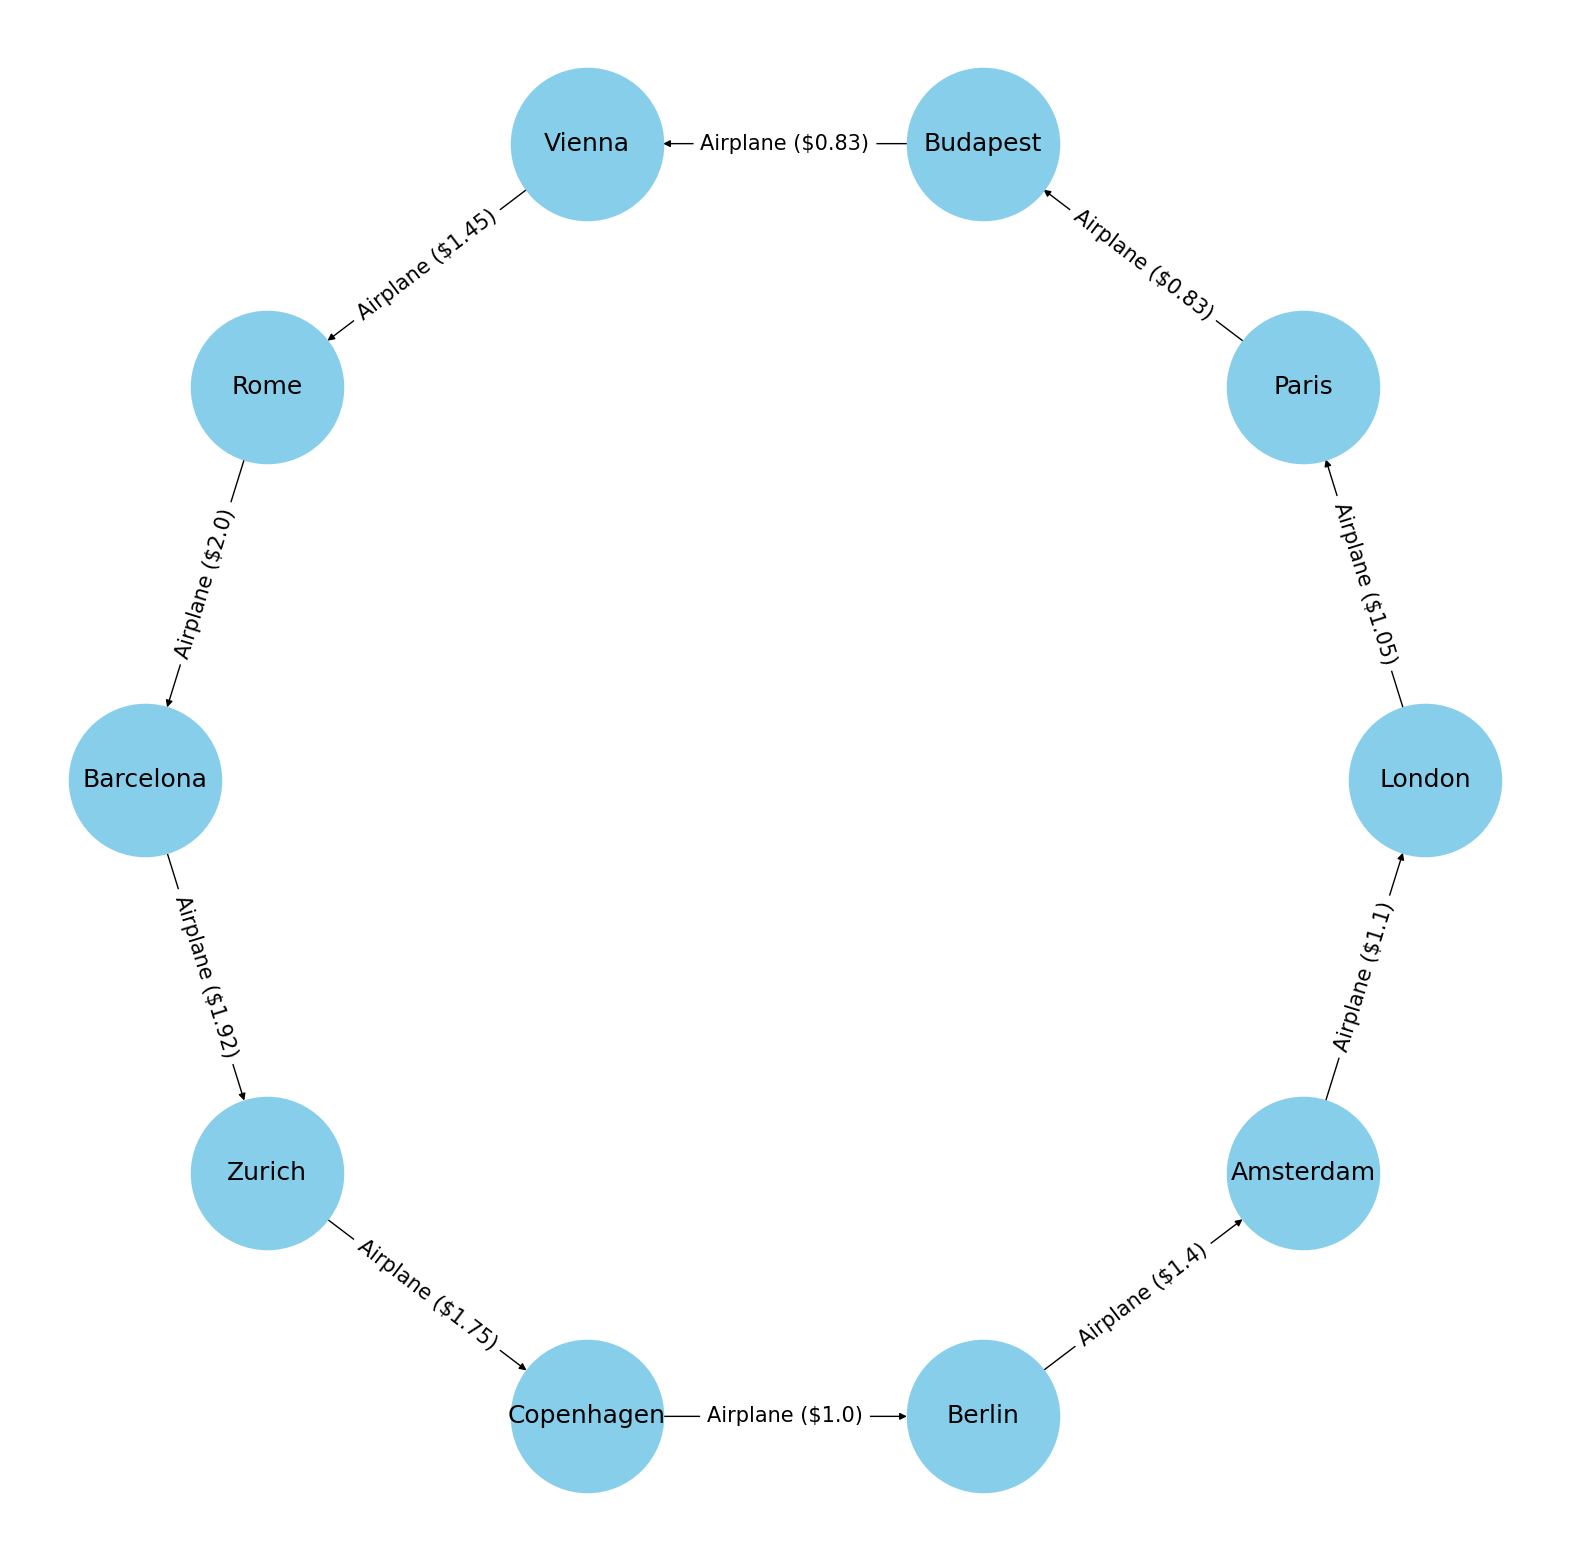

In [18]:
import matplotlib.pyplot as plt
import networkx as nx


def draw_graph(optimal_path, optimal_transport, flight_df, train_df):
    plt.rc('font', family='Menlo')
    G = nx.DiGraph()
    edge_labels = {}

    for i in range(len(optimal_path) - 1):
        G.add_edge(optimal_path[i], optimal_path[i + 1])
        transport = optimal_transport[i]
        cost = flight_df.loc[optimal_path[i], optimal_path[i + 1]] if transport == 'Airplane' else train_df.loc[
            optimal_path[i], optimal_path[i + 1]]
        edge_labels[(optimal_path[i], optimal_path[i + 1])] = f"{transport} (${cost})"

    pos = nx.circular_layout(G)
    fig, ax = plt.subplots(figsize=(20, 20))  # 调整画布大小
    nx.draw(G, pos, with_labels=True, node_size=12000, node_color="skyblue", font_size=18, font_weight='regular',
            arrows=True, ax=ax)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=15, font_weight='regular', ax=ax)
    plt.axis('off')
    plt.show()


draw_graph(optimal_path, optimal_transport, flight_df, train_df)
